# ⚡ 4 Function Calling (with KernelFunctions)

⚠️ Note function-calling compatible GPT models: (https://platform.openai.com/docs/guides/function-calling).

![Dotned - Hilversum.pptx.png](<attachment:Dotned - Hilversum.pptx.png>)
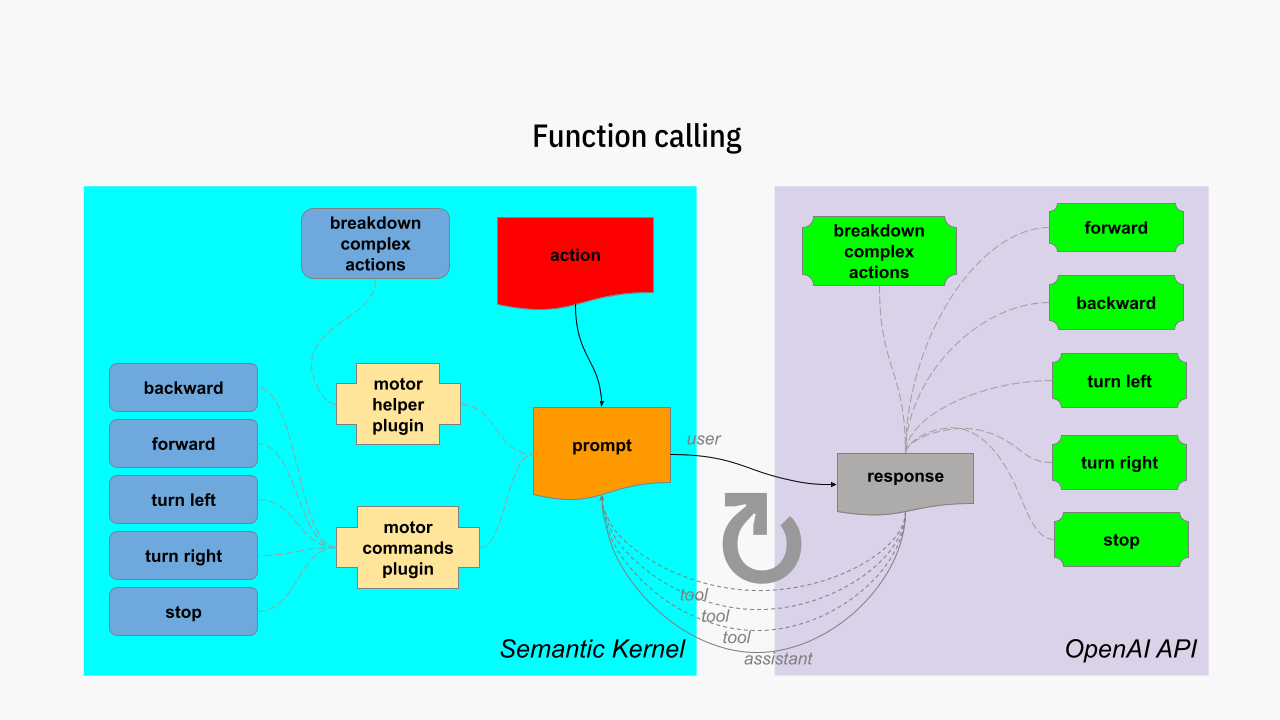

### Initialize the kernel

In [1]:
#r "nuget: Microsoft.SemanticKernel, 1.15.0"
#r "nuget: Microsoft.SemanticKernel.Plugins.Core, 1.15.0-alpha"

#!import Secrets.cs

using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.Connectors.OpenAI;

var kernel = Kernel.CreateBuilder()
    // .AddAzureOpenAIChatCompletion(
    //     deploymentName: Secrets.DeploymentName,
    //     endpoint: Secrets.Endpoint,
    //     apiKey: Secrets.ApyKey)
    .AddOpenAIChatCompletion(
        modelId: Secrets.OpenAIModel,
        apiKey: Secrets.OpenAIApiKey)    
    .Build();

Installed Packages Microsoft.SemanticKernel, 1.15.0 Microsoft.SemanticKernel.Plugins.Core, 1.15.0-alpha

### 🔌 Let's use a native function plugin.

In [2]:
using System.ComponentModel;

public class DateTimePlugin
{
    [KernelFunction]
    [Description("Retrieves the current date.")]
    public string GetCurrentDate() => DateTime.Now.ToShortDateString();
}

kernel.ImportPluginFromType<DateTimePlugin>("date");

### 📋 Let's prepare the execution settings and the kernel arguments.

In [6]:
using System.Text.Json;
using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.ChatCompletion;
using Microsoft.SemanticKernel.Connectors.OpenAI;
using Microsoft.Extensions.DependencyInjection;
using Microsoft.Extensions.Logging;
using Azure.AI.OpenAI;

var chat = kernel.GetRequiredService<IChatCompletionService>();
var chatHistory = new ChatHistory();

var executionSettings = new OpenAIPromptExecutionSettings
{
    ToolCallBehavior = ToolCallBehavior.EnableKernelFunctions 
};

chatHistory.AddUserMessage("How many days until Christmas?");
while (true)
{
    var result = (OpenAIChatMessageContent)await chat.GetChatMessageContentAsync(chatHistory, executionSettings, kernel);

    if (result.Content is not null)
    {
        Console.Write(result.Content);
    }

    List<ChatCompletionsFunctionToolCall> toolCalls = result.ToolCalls.OfType<ChatCompletionsFunctionToolCall>().ToList();
    if (toolCalls.Count == 0)
    {
        break;
    }

    chatHistory.Add(result);
    foreach (var toolCall in toolCalls)
    {
        string content = kernel.Plugins.TryGetFunctionAndArguments(toolCall, out KernelFunction? function, out KernelArguments arguments) 
            ? JsonSerializer.Serialize((await function.InvokeAsync(kernel, arguments)).GetValue<object>()) 
            : "Unable to find function. Please try again!";

        if (function != null)
        {
            Console.WriteLine($"  >> 🔌 {toolCall.Name.ToString()}: /{function.Name}");
        }

        Console.WriteLine($"       Result: {content}");

        chatHistory.Add(new ChatMessageContent(
            AuthorRole.Tool,
            content,
            metadata: new Dictionary<string, object>(1) { { OpenAIChatMessageContent.ToolIdProperty, toolCall.Id } }));
    }
}

  >> 🔌 date-GetCurrentDate: /GetCurrentDate
       Result: "6/21/2024"
Christmas is celebrated on December 25th. Let’s calculate the number of days from today (June 21, 2024) until Christmas.

1. From June 21 to June 30: \( 30 - 21 = 9 \) days
2. Full months from July to November:
   - July: 31 days
   - August: 31 days
   - September: 30 days
   - October: 31 days
   - November: 30 days
   - Total: \( 31 + 31 + 30 + 31 + 30 = 153 \) days
3. From December 1 to December 25: 25 days

Adding all these: 
\[ 9 (June) + 153 (Full months) + 25 (December) = 187 \]

There are 187 days until Christmas.